# Setup

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

## Read in Data

In [2]:
hitters = pd.read_csv("Hitters.csv")
hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


## EDA and Cleaning

In [3]:
# Rename unnamed column
hitters.rename(columns = {"Unnamed: 0": "PlayerName"}, inplace = True)

# Number of missing values
hitters.apply(lambda x: len(x) - x.count(), axis = 0)

PlayerName     0
AtBat          0
Hits           0
HmRun          0
Runs           0
RBI            0
Walks          0
Years          0
CAtBat         0
CHits          0
CHmRun         0
CRuns          0
CRBI           0
CWalks         0
League         0
Division       0
PutOuts        0
Assists        0
Errors         0
Salary        59
NewLeague      0
dtype: int64

In [4]:
# As a percentage of the total
hitters.apply(lambda x: (len(x) - x.count()) / len(x), axis = 0)

PlayerName    0.00000
AtBat         0.00000
Hits          0.00000
HmRun         0.00000
Runs          0.00000
RBI           0.00000
Walks         0.00000
Years         0.00000
CAtBat        0.00000
CHits         0.00000
CHmRun        0.00000
CRuns         0.00000
CRBI          0.00000
CWalks        0.00000
League        0.00000
Division      0.00000
PutOuts       0.00000
Assists       0.00000
Errors        0.00000
Salary        0.18323
NewLeague     0.00000
dtype: float64

18% missingness is a bit high, but probably acceptable to just eliminate for this situation.  

A more thorough analysis would check for possible correlation with missingness.

In [5]:
# Remove NAs.  File is small enough to keep both in memory.
hitters_clean = hitters.dropna()
# As a percentage of the total
hitters_clean.apply(lambda x: (len(x) - x.count()) / len(x), axis = 0)

PlayerName    0.0
AtBat         0.0
Hits          0.0
HmRun         0.0
Runs          0.0
RBI           0.0
Walks         0.0
Years         0.0
CAtBat        0.0
CHits         0.0
CHmRun        0.0
CRuns         0.0
CRBI          0.0
CWalks        0.0
League        0.0
Division      0.0
PutOuts       0.0
Assists       0.0
Errors        0.0
Salary        0.0
NewLeague     0.0
dtype: float64

There we go.  The null values have been removed.  Since we're dealing with types of regression, it's not generally necessary to normalize the values between 0 and 1.

In line with the instructions, however, we do need to remove non-numeric variables.  I also like to run a correlation matrix to see what values are likely correlated with my target.  Not part of the directions, but I'm fairly used to it.

Please note that this correlation matrix is taken, with some modification, from https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

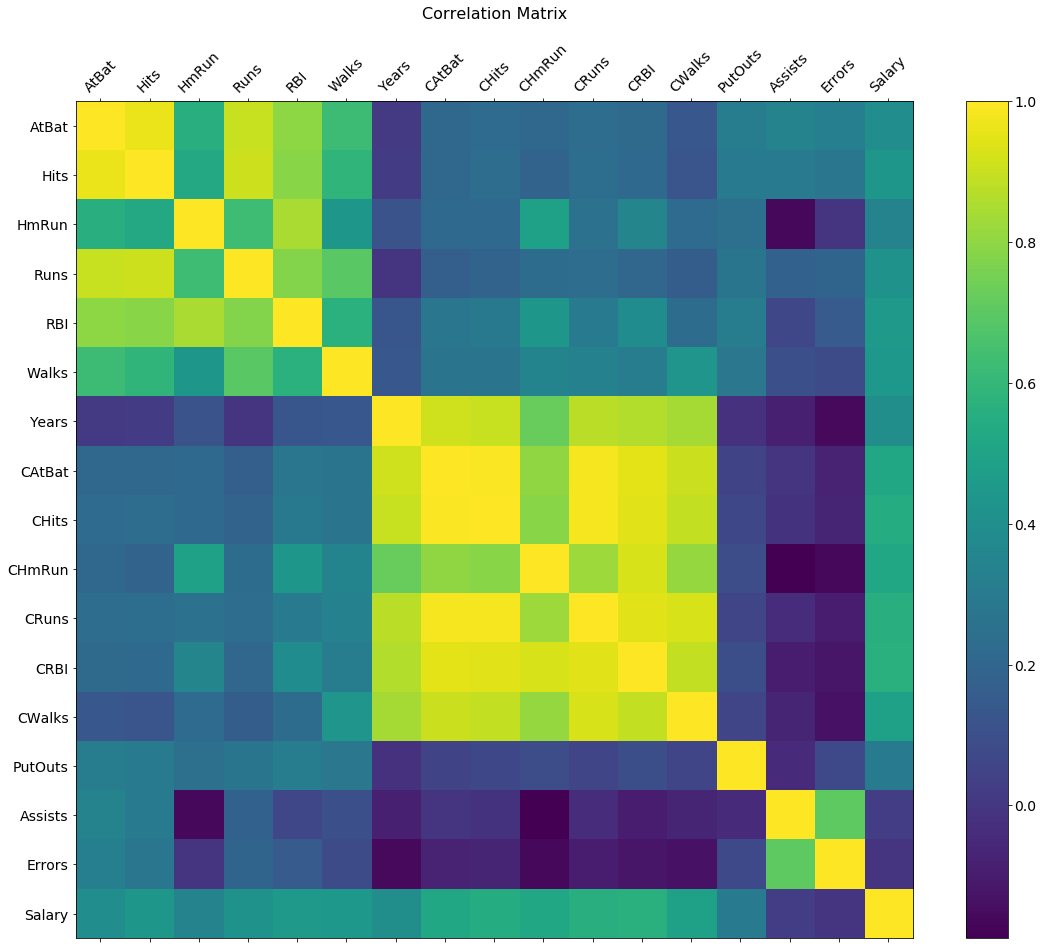

In [6]:
# Correlations
# Need to remove non-numeric columns anyway
hitters = hitters_clean.drop(['PlayerName', 'League', 'Division', 'NewLeague'], axis = 1)

# Plotting
f = plt.figure(figsize=(19, 15))
plt.matshow(hitters.corr(), fignum=f.number)
plt.xticks(range(hitters.shape[1]),hitters.columns, fontsize=14, rotation=45)
plt.yticks(range(hitters.shape[1]), hitters.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix\n\n', fontsize=16);

It does look as if many of the variables are at least somewhat correlated with salary.  Additionally, It looks like there's a great deal of correlation between a couple of groups of predictors which would result in probably very significant multi-collinearity.  A more through analysis would also try to deal with this.

# Question 1.1 - LASSO Regression

a. Use LASSO regression to predict Salary from the other numeric predictors.
b1. Create a visualization of the coefficient trajectories. 
b2. Comment on which are the final three predictors that remain in the model. 
c1. Use cross-validation to find the optimal value of the regularization penality. 
c2. How many predictors are left in that model?

## Setup

In [7]:
# Regression function

def lasso_reg(preds, tgt, alpha):
    
    results = Lasso(alpha = alpha, normalize = True, max_iter = 1e6)
    results.fit(preds, tgt)
    
    return results.coef_
    
# Alphas
alphas = np.logspace(-3, 1.5, 500)

# Matrices
y = hitters[['Salary']]
X = hitters.loc[:, hitters.columns != 'Salary']

# Other Vars
trajectories = []
col_names = list(hitters.columns)
preds_names = col_names[0:-1]
at_zero = [0] * len(preds_names)
lines = []

I'm just running through each alpha.  I based these on a log scale to help save room on the axis.  I'm not performing cross-validation at this point as this is just to track the trajectories.

In [8]:
# Run through each alpha and collect coefficients
for a in alphas:
    trajectories.append(lasso_reg(X, y, a))

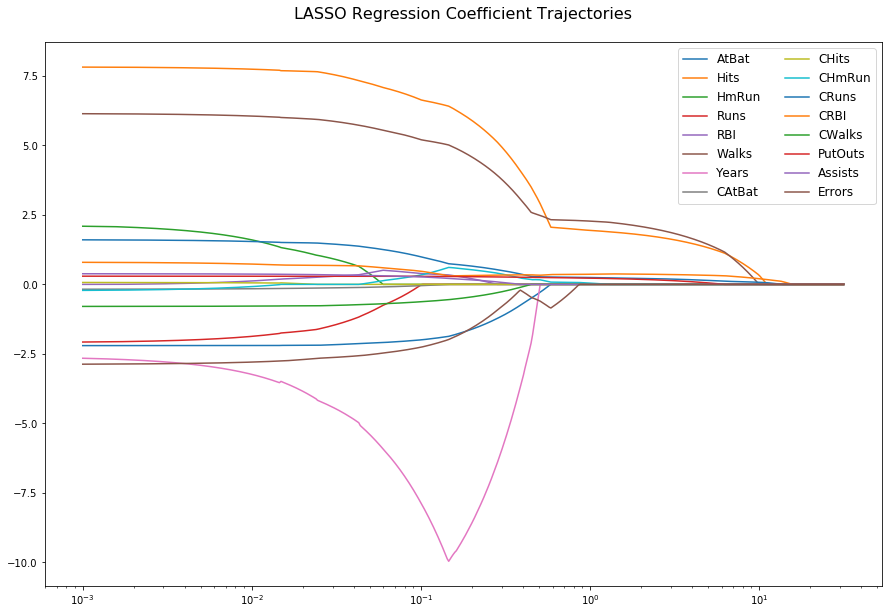

In [9]:
# Plot it Setup
coeffs = np.stack(trajectories, axis = -1)

for coef in range(len(coeffs)):
    lines.append(coeffs[coef,:])

# Plotting
f = plt.figure(figsize=(15, 10))
plt.xscale('log')

for line in lines:
    plt.plot(alphas, line)
     
plt.title('LASSO Regression Coefficient Trajectories\n', fontsize=16)
plt.legend(preds_names, fontsize = 12, ncol = 2)

plt.show()

Above, you can see the trajectories of the coefficients as alpha is ajusted and the rate at which they go to 0.

In [10]:
# Last 3 to go to 0

at_zeros = [0] * len(preds_names)
    
for i, line in enumerate(lines):
    for j, x in enumerate(line):
        if at_zeros[i] == 0 and x == 0:
            at_zeros[i] = j

combined = []

for index, name in zip(at_zeros, preds_names):
    combined.append([index, name])
    
highest = sorted(combined, key = lambda x: x[0])
highest[-3:]

[[449, 'Hits'], [459, 'CRuns'], [466, 'CRBI']]

Based on the trajectories displayed above, the final three variables to reach 0 are Hits, CRuns, and CRBI.  The number included is the index in the vector of alphas.  The high number correspond to near the end of the 500 points in the list of alphas.

I decided to use MSE in evaluating the models as opposed to $R^2$ as we're looking eventually at the bias-variance tradeoff and MSE can be decomposed to these componenets and the bias-variance tradeoff relationship is more easily understood in this manner.  I also just averaged the MSEs from each fold in the cross-validation to arrive at the metric to judge the final model by.  It's not perhaps the optimum method, but fine for these circumstances.

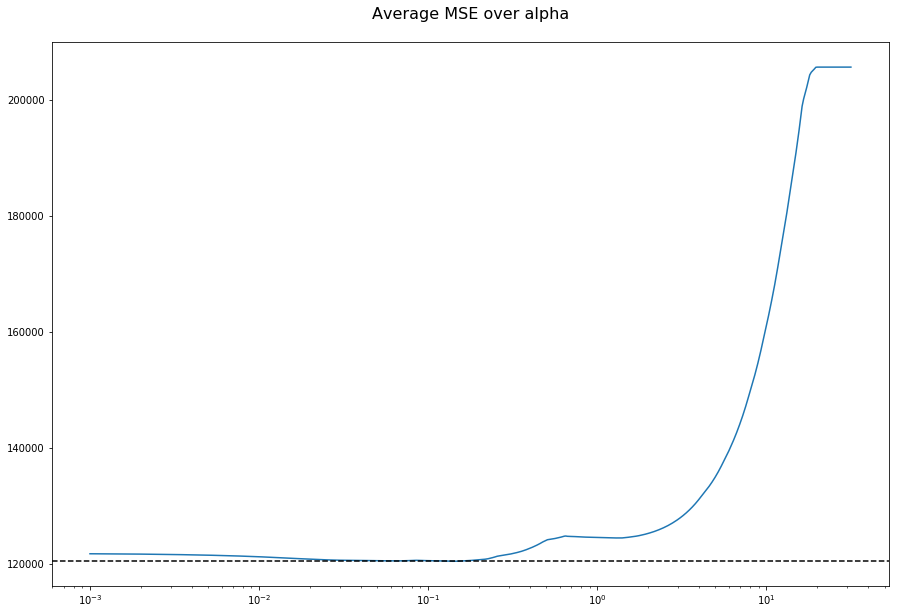

In [11]:
# Use cross-validation to determine the optimum hyper-parameter value for alpha
X = X.as_matrix()
y = y.as_matrix()

kf = KFold(n_splits = 5)
kf.get_n_splits(X)

Avg_MSE_by_alpha = []

for a in alphas:
    
    errors = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        clf = Lasso(alpha = a, normalize = True, max_iter = 1e6)
        clf.fit(X_train, y_train)
        errors.append(mean_squared_error(y_test, clf.predict(X_test)))
        
    Avg_MSE_by_alpha.append(np.average(errors))
    
# Plotting
f = plt.figure(figsize=(15, 10))
plt.xscale('log')

plt.plot(alphas, Avg_MSE_by_alpha)
plt.axhline(y = min(Avg_MSE_by_alpha),ls = '--', color = 'black')   # Line at optimum values

plt.title('Average MSE over alpha\n', fontsize=16)
plt.show()


You can definitely see the increase in MSE as the model becomes very underfit at the end.  In fact, the plateau you see at the far right is probably from all coefficients hitting zero and the only factor left in the model will end up being the bias.

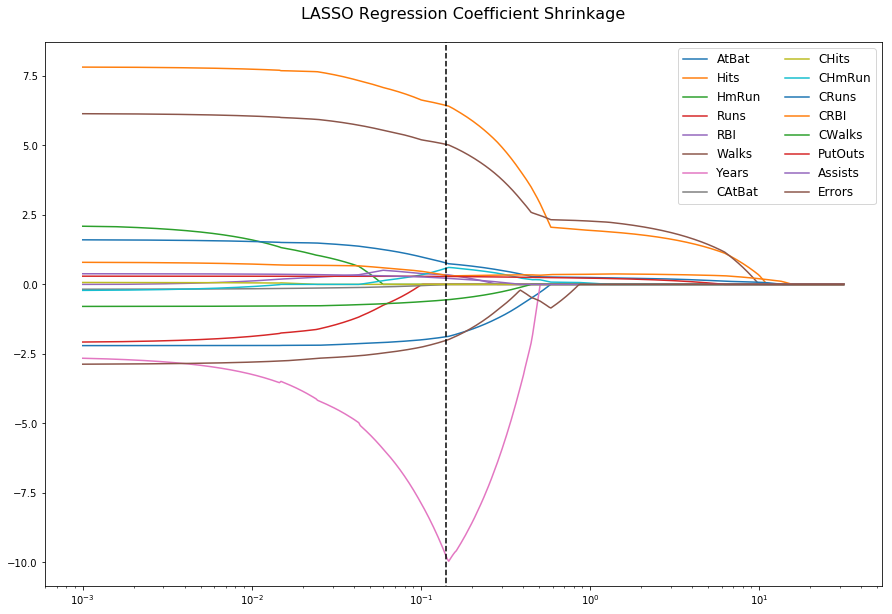

In [12]:
# Plotting
optimum = alphas[np.argmin(Avg_MSE_by_alpha)]

f = plt.figure(figsize=(15, 10))
plt.xscale('log')

for line in lines:
    plt.plot(alphas, line)
     
plt.title('LASSO Regression Coefficient Shrinkage\n', fontsize=16)
plt.legend(preds_names, fontsize = 12, ncol = 2)
plt.axvline(x = optimum, ymin = -10, ymax = 10, ls = '--', color = 'black')   # Line at optimum values

plt.show()

Above is the same graph with the optimum (minimum average MSE) location of alpha is shown by the vertical dashed line. You can definitely see that several of the variable coefficients are shrinking (with the exception of "Years").  This results in the complex model moving towards a simpler solution that overfits less.

In [13]:
coeffs_at_opt = lasso_reg(X, y, optimum)
temp = coeffs_at_opt.tolist()
print(f"The Optimal value of alpha: {optimum:1.4}\n")
print("Variable            Coefficient")
for name, coef in zip(preds_names, temp):
    print(f"{name:<20}{coef:1.4}")

The Optimal value of alpha: 0.1401

Variable            Coefficient
AtBat               -1.886
Hits                6.44
HmRun               -0.0
Runs                -0.0
RBI                 0.3468
Walks               5.041
Years               -9.734
CAtBat              -0.005501
CHits               0.0
CHmRun              0.5763
CRuns               0.7719
CRBI                0.3255
CWalks              -0.559
PutOuts             0.2851
Assists             0.2219
Errors              -2.02


# Question 1.2 - Ridge Regression

a. Repeat with Ridge Regression. 
b. Visualize coeffecient trajectories. 
c. Use crossvalidation to find the optimal vaule of the regularization penalty.

## Setup

In [14]:
# Regression function

def ridge_reg(preds, tgt, alpha):
    
    results = Ridge(alpha = alpha, normalize = True, max_iter = 1e6)
    results.fit(preds, tgt)
    
    return results.coef_
    
# Alphas
alphas = np.logspace(-5, 3, 500)

# Matrices
y = hitters[['Salary']]
X = hitters.loc[:, hitters.columns != 'Salary']

# Other Vars
trajectories = []
col_names = list(hitters.columns)
preds_names = col_names[0:-1]
at_zero = [0] * len(preds_names)
lines = []

In [15]:
# Run it through each alpha
for a in alphas:
    trajectories.append(ridge_reg(X, y, a))

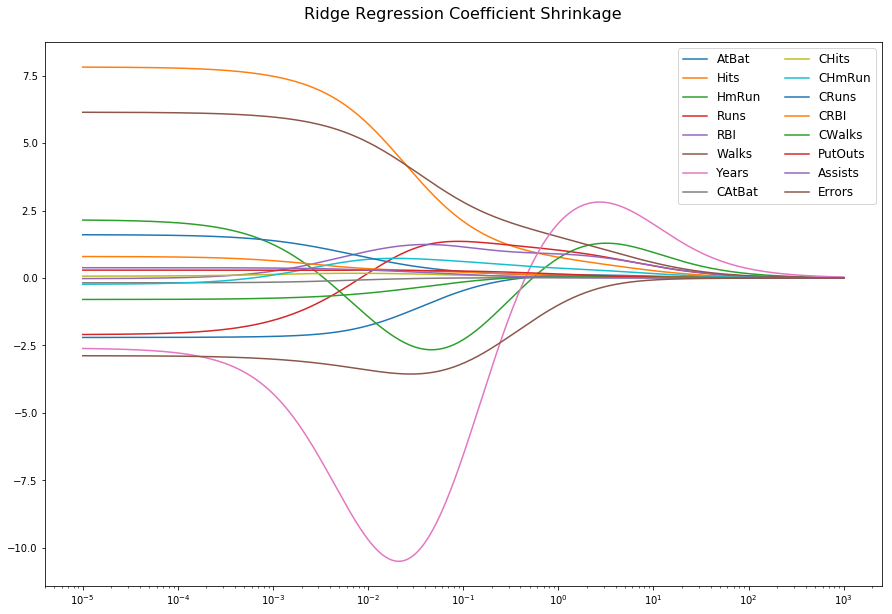

In [16]:
# Plot it Setup
del coeffs
coeffs = np.stack(trajectories, axis = -1)[0]

for coef in range(len(coeffs)):
    lines.append(coeffs[coef,:])

# Plotting
f = plt.figure(figsize=(15, 10))
plt.xscale('log')

for line in lines:
    plt.plot(alphas, line)
     
plt.title('Ridge Regression Coefficient Shrinkage\n', fontsize=16)
plt.legend(preds_names, fontsize = 12, ncol = 2)

plt.show()

Above, you can see the trajectories of the coefficients as alpha is ajusted and the rate at which they reduce to close to 0.  It should be noted that due to the operation of L2 regularization, the coefficients will never actually reach 0, but will approach it arbitraily closely as you increase alpha.

Due to this, I used a cutoff threshold of 0.05 for the size of a coefficient.  I realize that theoretically I should have normalized the variables to between 0 and 1 for this really to be a proper use of the threshold, for the purposes, this felt sufficient.

In [17]:
# Last 3 below threshold = 0.05

at_zeros = [0] * len(preds_names)
    
for i, line in enumerate(lines):
    for j, x in enumerate(line):
        if at_zeros[i] == 0 and x < 0.05:
            at_zeros[i] = j

combined = []

for index, name in zip(at_zeros, preds_names):
    combined.append([index, name])
    
highest = sorted(combined, key=lambda x: x[0])
highest[-3:]

[[371, 'CRBI'], [432, 'Hits'], [453, 'Walks']]

Based on the trajectories displayed above, the final three variables to fall below a threshold of (0.05) are CRBI, Hits, and Walks, very close to the results of the LASSO regression above.  The number included is the index in the vector of alphas to try. 

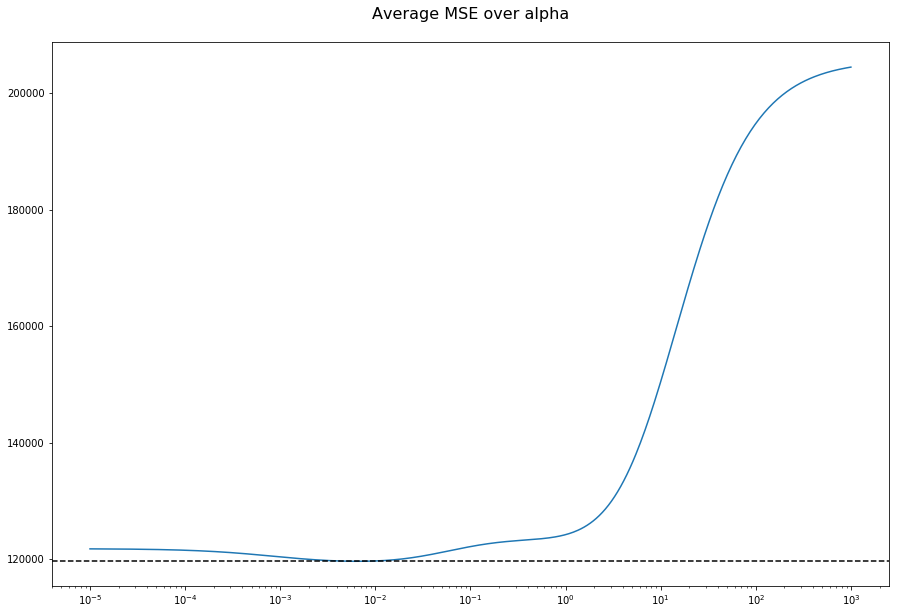

In [18]:
# Use cross-validation to determine the optimum hyper-parameter value for alpha
X = X.as_matrix()
y = y.as_matrix()

kf = KFold(n_splits = 5)
kf.get_n_splits(X)

Avg_MSE_by_alpha = []

for a in alphas:
    
    errors = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        clf = Ridge(alpha = a, normalize = True, max_iter = 1e6)
        clf.fit(X_train, y_train)
        errors.append(mean_squared_error(y_test, clf.predict(X_test)))
        
    Avg_MSE_by_alpha.append(np.average(errors))
    
# Plotting
f = plt.figure(figsize=(15, 10))
plt.xscale('log')

plt.plot(alphas, Avg_MSE_by_alpha)
plt.axhline(y = min(Avg_MSE_by_alpha),ls = '--', color = 'black')   # Line at optimum values

plt.title('Average MSE over alpha\n', fontsize=16)
plt.show()

Very similar results to the LASSO regression, though the graph is notably smoother.  It is approaching the same plateau on the right as the coefficients are approaching zero and the only thing left in the model is the bias.

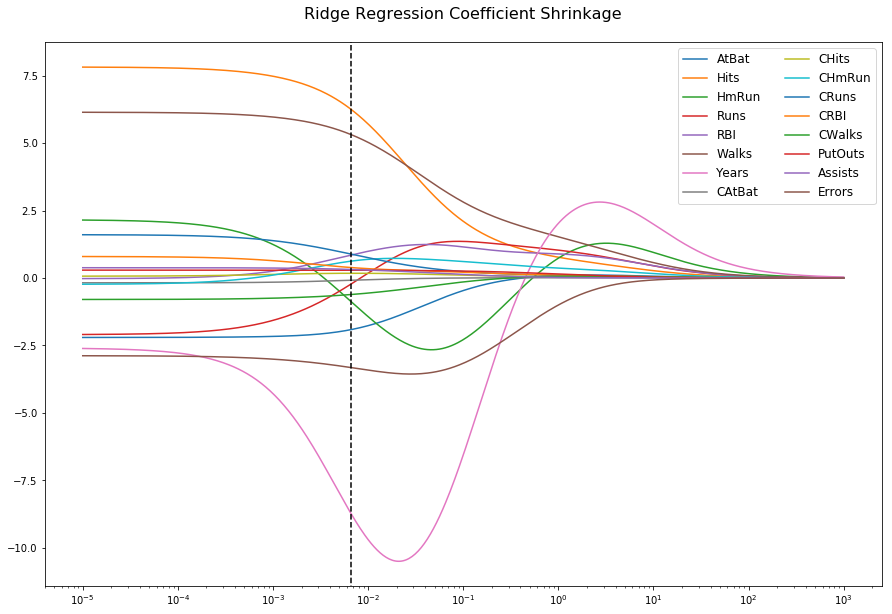

In [19]:
# Plotting
optimum = alphas[np.argmin(Avg_MSE_by_alpha)]

f = plt.figure(figsize=(15, 10))
plt.xscale('log')

for line in lines:
    plt.plot(alphas, line)
     
plt.title('Ridge Regression Coefficient Shrinkage\n', fontsize=16)
plt.legend(preds_names, fontsize = 12, ncol = 2)
plt.axvline(x = optimum, ymin = -10, ymax = 10, ls = '--', color = 'black')   # Line at optimum values

plt.show()

Above is the same graph with the optimum (minimum average MSE) location of alpha shown by the vertical dashed line.   As can be seen above, the model did reduce the impact of several of the variables to reduce overfitting.

In [20]:
coeffs_at_opt = lasso_reg(X, y, optimum)
temp = coeffs_at_opt.tolist()
print(f"The Optimal value of alpha: {optimum:1.4}\n")
print("Variable            Coefficient")
for name, coef in zip(preds_names, temp):
    print(f"{name:<20}{coef:1.4}")

The Optimal value of alpha: 0.006632

Variable            Coefficient
AtBat               -2.201
Hits                7.771
HmRun               1.79
Runs                -1.947
RBI                 0.07355
Walks               6.088
Years               -3.019
CAtBat              -0.1638
CHits               0.06032
CHmRun              -0.1309
CRuns               1.566
CRBI                0.7543
CWalks              -0.786
PutOuts             0.2949
Assists             0.3751
Errors              -2.824


In the list of predictors shown above with the Ridge regression run with the optimal hyperparameter value of 0.0066, none of the predictors were non-zero, as to be expected with Ridge Regression.  That said, based on the shrinkage seen on the graph (excepting Years), the regularization was working to create a simpler graph.

# Question 2 - Explain the bias-variance tradeoff

When creating predictive models, two common sources of error are bias and variance.  In the most simple terms, bias refers to whether or not your model is actually estimating the correct target (are you aiming at the right thing, usually the mean) while variance refers to the how much as estimate is likely to differ from the target (how well you shoot, ie. the amount of your estimates' spread from the mean).  While not the only sources of error in a model, these two are of particular interest because they are both part of Total Error and how they typically interact when constructing models.

$Total Error=E[(Y-f\hat(x))^2]$

This can be decomposed into several components - $Bias^2$, $Variance$, and $Irreducible Error$ :

$Total Error=(E[f\hat(x)] - f(x))^2 + E[(f\hat(x) - E[(f\hat(x)])^2] + \sigma^2_e$

Simple models (underfit models) typically have high bias because they oversimplify and can't capture all the actual signal in the data.  This simplicity, however, typically results in low variance.  Complex models (overfit models), however, end up capturing most of the actual signal, resulting in low bias.  This complexity, also captures the noise in the data and often results in high variance. 
 
The bias-variance tradeoff refers to minimizing Total Error by trading off some bias and variance until you arive at the optimal model.  Regularization is a method of penalizing the weights (coefficients in this case) of the variables in the model to reduce overfitting and is controlled by the hyperparameter $\alpha$.  A low value for $\alpha$ (close to 0) results in a model that is very close to OLS regression estimates (sometimes $\alpha$ is referred to as $\lambda$).  Larger values for $\alpha$ (close to 1) have large penalties and reduce the contrubution of the variables to the model and simplify the model.  This reduction in contribution helps to reduce model overfitting, i.e. variance introduced in complex models.

LASSO utilizes L1 regularization, while Ridge regression utilizes L2 regularization.  Both demonstrated methods of regularization work to reduce the contribution of each variable to the final prediction.  One significant difference is that L1 regularization ends up driving coefficients to zero, which helps to create a more parsimonious model, while L2 generally shrinks their impact, but never eliminates them.  Other types of regularization exist as do hybrid versions, such as elastic-net, which combines both L1 and L2.

In part one, our experiments demonstrated this trade-off, focusing on the impact regularization has on Total Error.  Both models began with all numeric variables added and $\alpha$ close to 0 - a fairly complex model.  As we tested $\alpha$ over a range of values (close to 0 to close to 1), we essentially began with a model with high complexity and traded off bias and variance to get to a model with low complexity.  While the initial fall in MSE was small compared to the final increase, in both cases, the Total Error fell for a bit as model overfitting was reduced by regularization, then rose again as the model became too simple (biased).